### Data Science Capstone: College Scorecard Investigation

In this file, I am using the most recent data from the US Department of Education's College Scorecard for the 2021-2022 school year to investigate a number of questions. 

> 1. How does the median debt at graduation vary across different Carnegie classifications of institutions?
> 2. Are there regional trends in graduation rates?
> 3. Does the selectivity of an institution (e.g., acceptance rate) correlate with its graduation rates?
> 4. Do public vs. private vs. for-profit institutions show distinct patterns in costs, debt, or graduation rates?
> 5. What factors drive graduation rates?

In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor as RFR
from scipy import stats
from sklearn.inspection import PartialDependenceDisplay 
%matplotlib inline

In [174]:
df = pd.read_csv("Most-Recent-Cohorts-Institution.csv",low_memory=False)

In [175]:
def ffill_df(old_df):
    """
    Forward fills selected columns from a DataFrame and creates a new columns
    
    Args:
        old_df (pandas.DataFrame): The raw DataFrame with the relevant columns
    Returns: 
        pandas.DataFrame: A new DataFrame with a new column with consolidated values for the selected columns
    """
  
    df_c150 = old_df[['C150_4','C150_L4']].copy()
    df_c150.ffill(axis=1,inplace=True)
    old_df['FULL_C150'] = df_c150['C150_L4']

    df_ret = old_df[['RET_FT4','RET_FTL4']].copy()
    df_ret.ffill(axis=1,inplace=True)
    old_df['FULL_RET_FT'] = df_ret['RET_FTL4']

    df_cost = old_df[['COSTT4_A','COSTT4_P']].copy()
    df_cost.ffill(axis=1,inplace=True)
    old_df['FULL_COSTT'] = df_cost['COSTT4_P']
    new_df = old_df.copy()
    return new_df

In [222]:
def clean_data(old_df,year):
    """
    Cleans and preprocesses a DataFrame of college scorecard data.
    
    Args:
        old_df (pandas.DataFrame): The raw DataFrame containing college data.
        year (int): The year to be associated with the data.

    Returns:
        pandas.DataFrame: A new DataFrame with the following modifications:
            - Missing values filled as described above.
            - 'PrivacySuppressed' values replaced with NaN.
            - 'YEAR' column added.
    """
    ffill_df(old_df)
    old_df = old_df.replace('PrivacySuppressed', np.nan)
    new_df = old_df.copy()
    new_df['YEAR'] = year
    return new_df

In [177]:
df_2021_clean = clean_data(df,2021)
df_2021_clean.head(20)


,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,OMAWDP8_NOPELL_NOTFIRSTTIME,OMENRUP_NOPELL_NOTFIRSTTIME,OMACHT8_NOPELL_ALL,OMACHT8_NOPELL_FIRSTTIME,OMACHT8_NOPELL_NOTFIRSTTIME,ADDR,FULL_C150,FULL_RET_FT,FULL_COSTT,YEAR
0,100654,100200.0,1002.0,Alabama A & M University,Normal,AL,35762,Southern Association of Colleges and Schools C...,www.aamu.edu/,www.aamu.edu/admissions-aid/tuition-fees/net-p...,...,0.4744,0.2179,329.0,251.0,78.0,4900 Meridian Street,0.2807,0.5797,21924.0,2021
1,100663,105200.0,1052.0,University of Alabama at Birmingham,Birmingham,AL,35294-0110,Southern Association of Colleges and Schools C...,https://www.uab.edu/,https://tcc.ruffalonl.com/University of Alabam...,...,0.5136,0.2117,2358.0,1182.0,1176.0,Administration Bldg Suite 1070,0.6245,0.8392,26248.0,2021
2,100690,2503400.0,25034.0,Amridge University,Montgomery,AL,36117-3553,Southern Association of Colleges and Schools C...,https://www.amridgeuniversity.edu/,https://www2.amridgeuniversity.edu:9091/,...,0.4583,0.2083,26.0,2.0,24.0,1200 Taylor Rd,0.4444,NaN,NaN,2021
3,100706,105500.0,1055.0,University of Alabama in Huntsville,Huntsville,AL,35899,Southern Association of Colleges and Schools C...,www.uah.edu/,finaid.uah.edu/,...,0.5948,0.1324,1122.0,510.0,612.0,301 Sparkman Dr,0.6072,0.7899,24869.0,2021
4,100724,100500.0,1005.0,Alabama State University,Montgomery,AL,36104-0271,Southern Association of Colleges and Schools C...,www.alasu.edu/,www.alasu.edu/cost-aid/tuition-costs/net-price...,...,0.3667,0.4889,510.0,420.0,90.0,915 S Jackson Street,0.2843,0.6436,21938.0,2021
5,100751,105100.0,1051.0,The University of Alabama,Tuscaloosa,AL,35487-0100,Southern Association of Colleges and Schools C...,www.ua.edu/,financialaid.ua.edu/net-price-calculator/,...,0.6292,0.1261,6774.0,5315.0,1459.0,739 University Blvd,0.7223,0.8855,31050.0,2021
6,100760,100700.0,1007.0,Central Alabama Community College,Alexander City,AL,35010,Southern Association of Colleges and Schools C...,www.cacc.edu/,https://www.cacc.edu/net-price-calculator/,...,0.2958,0.5634,310.0,239.0,71.0,1675 Cherokee Rd,0.2190,0.6356,13930.0,2021
7,100812,100800.0,1008.0,Athens State University,Athens,AL,35611,Southern Association of Colleges and Schools C...,www.athens.edu/,www.athens.edu/financial-aid/net-price-calcula...,...,0.6219,0.2216,677.0,0.0,677.0,300 N Beaty St,NaN,NaN,NaN,2021
8,100830,831000.0,8310.0,Auburn University at Montgomery,Montgomery,AL,36117-3596,Southern Association of Colleges and Schools C...,www.aum.edu/,www.aum.edu/current-students/financial-informa...,...,0.4962,0.2348,646.0,382.0,264.0,7440 East Drive,0.3569,0.6303,20621.0,2021
9,100858,100900.0,1009.0,Auburn University,Auburn,AL,36849,Southern Association of Colleges and Schools C...,www.auburn.edu/,https://www.auburn.edu/admissions/costcalc/fre...,...,0.7347,0.0644,4154.0,3253.0,901.0,"Auburn, Alabama",0.8088,0.9289,32678.0,2021


In [178]:
df_2020 = pd.read_csv("MERGED2020_21_PP.csv",low_memory=False)

In [179]:
df_2020 = df_2020[df_2020['UNITID'].isin(df_2021_clean['UNITID'])]
df_2020_clean = clean_data(df_2020,2020)
two_year_df = df_2021_clean.combine_first(df_2020_clean)
two_year_df.head(20)

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,OMAWDP8_NOPELL_NOTFIRSTTIME,OMENRUP_NOPELL_NOTFIRSTTIME,OMACHT8_NOPELL_ALL,OMACHT8_NOPELL_FIRSTTIME,OMACHT8_NOPELL_NOTFIRSTTIME,ADDR,FULL_C150,FULL_RET_FT,FULL_COSTT,YEAR
0,100654,100200.0,1002.0,Alabama A & M University,Normal,AL,35762,Southern Association of Colleges and Schools C...,www.aamu.edu/,www.aamu.edu/admissions-aid/tuition-fees/net-p...,...,0.4744,0.2179,329.0,251.0,78.0,4900 Meridian Street,0.2807,0.5797,21924.0,2021
1,100663,105200.0,1052.0,University of Alabama at Birmingham,Birmingham,AL,35294-0110,Southern Association of Colleges and Schools C...,https://www.uab.edu/,https://tcc.ruffalonl.com/University of Alabam...,...,0.5136,0.2117,2358.0,1182.0,1176.0,Administration Bldg Suite 1070,0.6245,0.8392,26248.0,2021
2,100690,2503400.0,25034.0,Amridge University,Montgomery,AL,36117-3553,Southern Association of Colleges and Schools C...,https://www.amridgeuniversity.edu/,https://www2.amridgeuniversity.edu:9091/,...,0.4583,0.2083,26.0,2.0,24.0,1200 Taylor Rd,0.4444,0.5000,20100.0,2021
3,100706,105500.0,1055.0,University of Alabama in Huntsville,Huntsville,AL,35899,Southern Association of Colleges and Schools C...,www.uah.edu/,finaid.uah.edu/,...,0.5948,0.1324,1122.0,510.0,612.0,301 Sparkman Dr,0.6072,0.7899,24869.0,2021
4,100724,100500.0,1005.0,Alabama State University,Montgomery,AL,36104-0271,Southern Association of Colleges and Schools C...,www.alasu.edu/,www.alasu.edu/cost-aid/tuition-costs/net-price...,...,0.3667,0.4889,510.0,420.0,90.0,915 S Jackson Street,0.2843,0.6436,21938.0,2021
5,100751,105100.0,1051.0,The University of Alabama,Tuscaloosa,AL,35487-0100,Southern Association of Colleges and Schools C...,www.ua.edu/,financialaid.ua.edu/net-price-calculator/,...,0.6292,0.1261,6774.0,5315.0,1459.0,739 University Blvd,0.7223,0.8855,31050.0,2021
6,100760,100700.0,1007.0,Central Alabama Community College,Alexander City,AL,35010,Southern Association of Colleges and Schools C...,www.cacc.edu/,https://www.cacc.edu/net-price-calculator/,...,0.2958,0.5634,310.0,239.0,71.0,1675 Cherokee Rd,0.2190,0.6356,13930.0,2021
7,100812,100800.0,1008.0,Athens State University,Athens,AL,35611,Southern Association of Colleges and Schools C...,www.athens.edu/,www.athens.edu/financial-aid/net-price-calcula...,...,0.6219,0.2216,677.0,0.0,677.0,300 N Beaty St,NaN,NaN,NaN,2021
8,100830,831000.0,8310.0,Auburn University at Montgomery,Montgomery,AL,36117-3596,Southern Association of Colleges and Schools C...,www.aum.edu/,www.aum.edu/current-students/financial-informa...,...,0.4962,0.2348,646.0,382.0,264.0,7440 East Drive,0.3569,0.6303,20621.0,2021
9,100858,100900.0,1009.0,Auburn University,Auburn,AL,36849,Southern Association of Colleges and Schools C...,www.auburn.edu/,https://www.auburn.edu/admissions/costcalc/fre...,...,0.7347,0.0644,4154.0,3253.0,901.0,"Auburn, Alabama",0.8088,0.9289,32678.0,2021


In [180]:
df_2019 = pd.read_csv("MERGED2019_20_PP.csv",low_memory=False)

In [181]:
df_2019 = df_2019[df_2019['UNITID'].isin(df_2021_clean['UNITID'])]
df_2019_clean = clean_data(df_2019,2019)
three_year_df = two_year_df.combine_first(df_2019_clean)


In [182]:
df_2018 = pd.read_csv("MERGED2018_19_PP.csv",low_memory=False)
df_2018 = df_2018[df_2018['UNITID'].isin(df_2021_clean['UNITID'])]
df_2018_clean = clean_data(df_2018,2018)
four_year_df = three_year_df.combine_first(df_2018_clean)

In [183]:
df_2017 = pd.read_csv("MERGED2017_18_PP.csv",low_memory=False)
df_2017 = df_2017[df_2017['UNITID'].isin(df_2021_clean['UNITID'])]
df_2017_clean = clean_data(df_2017,2017)
five_year_df = four_year_df.combine_first(df_2017_clean)


In [184]:
five_year_df1 = five_year_df[['UNITID','HIGHDEG','CONTROL','AVGFACSAL','PFTFAC','PCTPELL','MD_EARN_WNE_P10','UGDS','UGDS_MEN','UGDS_WHITE','UGDS_BLACK','UGDS_HISP',
'UGDS_ASIAN','UGDS_AIAN','UGDS_NHPI','UGDS_2MOR','UGDS_NRA','UGDS_UNKN','PCTFLOAN','GRAD_DEBT_MDN','WDRAW_DEBT_MDN','ICLEVEL','STUFACR','FULL_RET_FT','FULL_COSTT',
'FULL_C150', 'YEAR',]].copy()

In [185]:
five_year_df1.shape[0] - five_year_df1.dropna().shape[0]

1651

#### How does the median debt at graduation vary across different Carnegie classifications of institutions?

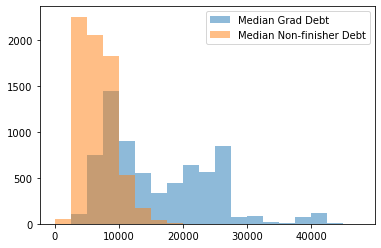

In [186]:
bins = np.arange(0, 50000,2500)
ps_dropped = five_year_df[~((five_year_df['GRAD_DEBT_MDN'] == 'PrivacySuppressed') | (five_year_df['WDRAW_DEBT_MDN'] == 'PrivacySuppressed'))].copy()
ps_dropped['GRAD_DEBT_MDN'] = pd.to_numeric(ps_dropped['GRAD_DEBT_MDN'], errors='coerce')
ps_dropped['WDRAW_DEBT_MDN'] = pd.to_numeric(ps_dropped['WDRAW_DEBT_MDN'], errors='coerce')

plt.hist(data=ps_dropped, x='GRAD_DEBT_MDN', bins=bins, alpha=0.5, label='Median Grad Debt');
plt.hist(data=ps_dropped, x='WDRAW_DEBT_MDN', bins=bins, alpha=0.5, label='Median Non-finisher Debt');
plt.legend();

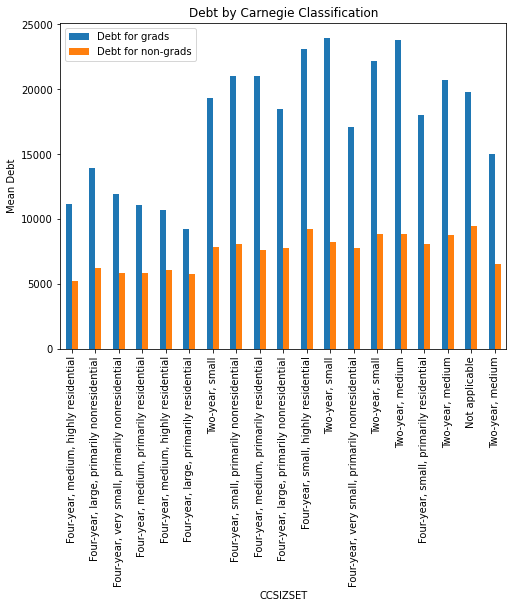

In [187]:
classification_mapping = {
    -2: "Not applicable",
    0: "(Not classified)",
    1: "Two-year, very small",
    2: "Two-year, small",
    3: "Two-year, medium",
    4: "Two-year, large",
    5: "Two-year, very large",
    6: "Four-year, very small, primarily nonresidential",
    7: "Four-year, very small, primarily residential",
    8: "Four-year, very small, highly residential",
    9: "Four-year, small, primarily nonresidential",
    10: "Four-year, small, primarily residential",
    11: "Four-year, small, highly residential",
    12: "Four-year, medium, primarily nonresidential",
    13: "Four-year, medium, primarily residential",
    14: "Four-year, medium, highly residential",
    15: "Four-year, large, primarily nonresidential",
    16: "Four-year, large, primarily residential",
    17: "Four-year, large, highly residential",
    18: "Exclusively graduate/professional"
}

grad_mean = ps_dropped.groupby(['CCSIZSET'])['GRAD_DEBT_MDN'].mean() 
wdraw_mean = ps_dropped.groupby(['CCSIZSET'])['WDRAW_DEBT_MDN'].mean()
grouped_df = pd.DataFrame({"Debt for grads": grad_mean, 'Debt for non-grads': wdraw_mean})

ax = grouped_df.plot.bar(figsize = (8,6),title="Debt by Carnegie Classification", 
                             xlabel="CCSIZSET", ylabel="Mean Debt", rot=90) 
labels = df['CCSIZSET'].map(classification_mapping).tolist() 
relevant_labels = labels[:len(grouped_df.index)]
ax.legend(loc='best') ;
ax.set_xticklabels(relevant_labels);

#### Are there regional trends in graduation rates?

In [223]:
def grouped_means_graph(df, x_axis, y_axis, fig_size):
    """
    Creates a bar chart of mean values for the y-axis grouped by the x-axis.

    Args:
        df: The pandas DataFrame containing the data to be plotted.
        x_axis: The column name in the DataFrame to use as the x-axis (grouping variable).
        y_axis: The column name in the DataFrame to use as the y-axis (value to average).
        fig_size: A tuple specifying the width and height of the figure (e.g., (10, 6)).

    Returns:
        The matplotlib Axes object representing the created plot.
    """
    
    grouped_df = df.groupby([x_axis])[y_axis].mean()
    ax = grouped_df.plot.bar(figsize=(fig_size),title = f"{x_axis} vs mean of {y_axis}", xlabel = x_axis, ylabel = (f'Mean {y_axis}'));
    return ax

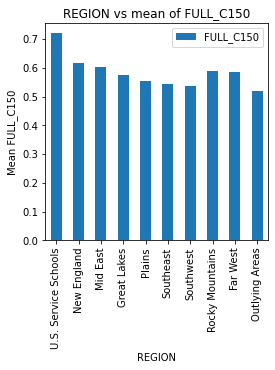

In [189]:
region_mapping = {
    0: "U.S. Service Schools",
    1: "New England",
    2: "Mid East",
    3: "Great Lakes",
    4: "Plains",
    5: "Southeast",
    6: "Southwest",
    7: "Rocky Mountains",
    8: "Far West",
    9: "Outlying Areas"
}
ax = grouped_means_graph(five_year_df, 'REGION', 'FULL_C150', (4,4))
grouped_df = five_year_df.groupby(['REGION'])['C150_4'].mean()
grouped_regions = grouped_df.index.tolist()
relevant_labels = [region_mapping[region_code] for region_code in grouped_regions]
ax.legend(loc='best')
ax.set_xticklabels(relevant_labels)
plt.show();

#### Does the selectivity of an institution (e.g., average SAT score or acceptance rate) correlate with its graduation rates?

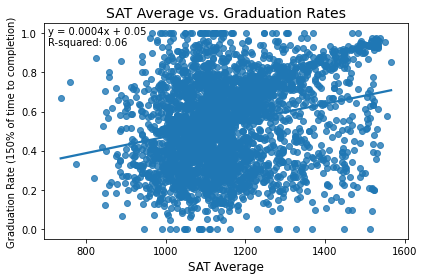

In [190]:
#sns.regplot(data=df, x='SAT_AVG', y='C150_4');
# Fit linear regression
# Create a subset of the data containing only the columns of interest.
df_subset = five_year_df[['SAT_AVG', 'FULL_C150']]

# Drop rows with NaN values in either of the columns.
df_subset_dropna = df_subset.dropna(subset=['SAT_AVG', 'FULL_C150'])

# Fit linear regression on the filtered DataFrame.
slope, intercept, r_value, _, _ = stats.linregress(
    df_subset_dropna['SAT_AVG'], df_subset_dropna['FULL_C150'])

# Create the regplot
ax = sns.regplot(data=five_year_df, x='SAT_AVG', y='FULL_C150', ci=None)

# Set title and labels
ax.set_title('SAT Average vs. Graduation Rates', fontsize=14)
ax.set_xlabel('SAT Average', fontsize=12)
ax.set_ylabel('Graduation Rate (150% of time to completion)', fontsize=10)  

# Add regression equation and R-squared as text
ax.text(0.01, 0.95, f"y = {slope:.4f}x + {intercept:.2f}", transform=ax.transAxes)
ax.text(0.01, 0.9, f"R-squared: {r_value**2:.2f}", transform=ax.transAxes)

# Show the plot
plt.tight_layout()
plt.show();

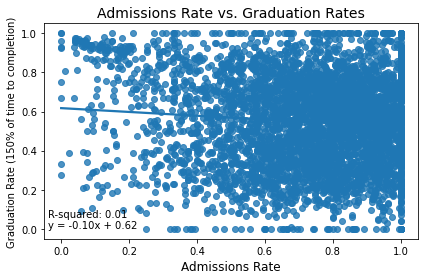

In [191]:
# Create a subset of the data containing only the columns of interest
df_subset = five_year_df[['ADM_RATE', 'FULL_C150']]

# Drop rows with NaN values in either of the columns
df_subset_dropna = df_subset.dropna(subset=['ADM_RATE', 'FULL_C150'])

# Fit linear regression on the filtered DataFrame
slope, intercept, r_value, _, _ = stats.linregress(
    df_subset_dropna['ADM_RATE'], df_subset_dropna['FULL_C150'])

# Create the regplot
ax = sns.regplot(data=five_year_df, x='ADM_RATE', y='FULL_C150', ci=None)

# Set title and labels
ax.set_title('Admissions Rate vs. Graduation Rates', fontsize=14)
ax.set_xlabel('Admissions Rate', fontsize=12)
ax.set_ylabel('Graduation Rate (150% of time to completion)', fontsize=10)

# Add regression equation and R-squared as text
ax.text(0.01, 0.05, f"y = {slope:.2f}x + {intercept:.2f}", transform=ax.transAxes)
ax.text(0.01, 0.1, f"R-squared: {r_value**2:.2f}", transform=ax.transAxes)

# Show the plot
plt.tight_layout()
plt.show()

#### Do public vs. private vs. for-profit institutions show distinct patterns in costs, debt, or graduation rates?

In [192]:
df_select = five_year_df[['SAT_AVG','ADM_RATE','CONTROL',"FULL_C150",'MD_EARN_WNE_P10','FULL_COSTT','PCTPELL','PCTFLOAN','GRAD_DEBT_MDN','WDRAW_DEBT_MDN']].copy()
control_mapping = {1: 'Public', 2: 'Private nonprofit', 3: 'Private for profit'}
df_select['CONTROL'] = df_select['CONTROL'].map(control_mapping)
classes = ['Public','Private nonprofit', 'Private for profit']
typeclasses = pd.CategoricalDtype(ordered=True, categories=classes)
df_select['CONTROL'] = df_select['CONTROL'].astype(typeclasses);

ps_dropped_select = df_select[~((df_select['GRAD_DEBT_MDN'] == 'PrivacySuppressed') | (df_select['WDRAW_DEBT_MDN'] == 'PrivacySuppressed'))].copy()
ps_dropped_select['GRAD_DEBT_MDN'] = pd.to_numeric(ps_dropped_select['GRAD_DEBT_MDN'], errors='coerce')
ps_dropped_select['WDRAW_DEBT_MDN'] = pd.to_numeric(ps_dropped_select['WDRAW_DEBT_MDN'], errors='coerce')

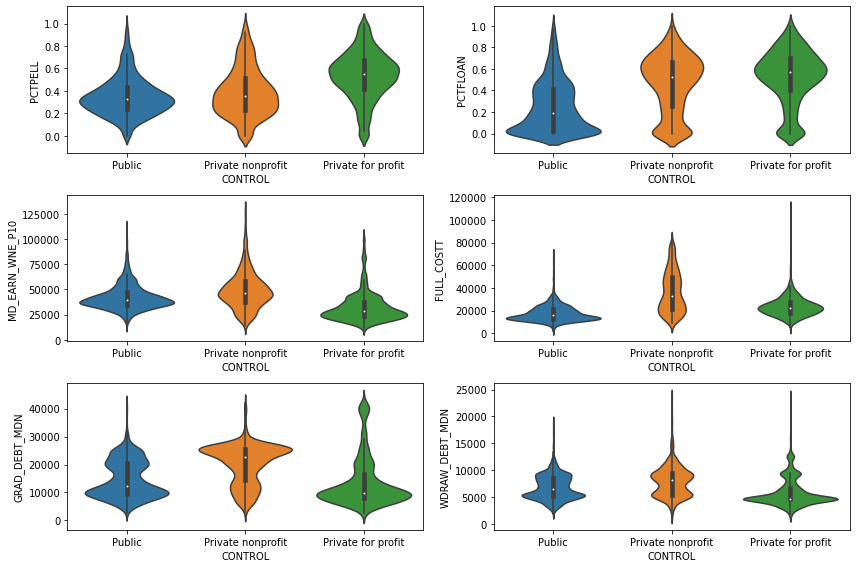

In [193]:
# Create a 2x3 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))  # Adjust figsize as needed

# Plot data on each subplot
sns.violinplot(ax=axes[0, 0], data=df_select, x='CONTROL', y='PCTPELL')  # Top-left subplot
sns.violinplot(ax=axes[0, 1], data=df_select, x='CONTROL', y='PCTFLOAN')  # Top-middle subplot
sns.violinplot(ax=axes[1, 0], data=df_select, x='CONTROL', y='MD_EARN_WNE_P10')  # Bottom-left subplot
sns.violinplot(ax=axes[1, 1], data=df_select, x='CONTROL', y='FULL_COSTT')  
sns.violinplot(ax=axes[2, 0],data=ps_dropped_select, x='CONTROL', y='GRAD_DEBT_MDN')
sns.violinplot(ax=axes[2, 1],data=ps_dropped_select, x='CONTROL', y='WDRAW_DEBT_MDN');

# Adjust layout and show
plt.tight_layout()
plt.show()

#### What factors drive graduation rates?

In [194]:
five_year_df

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,OMAWDP8_NOPELL_NOTFIRSTTIME,OMENRUP_NOPELL_NOTFIRSTTIME,OMACHT8_NOPELL_ALL,OMACHT8_NOPELL_FIRSTTIME,OMACHT8_NOPELL_NOTFIRSTTIME,ADDR,FULL_C150,FULL_RET_FT,FULL_COSTT,YEAR
0,100654,100200.0,1002.0,Alabama A & M University,Normal,AL,35762,Southern Association of Colleges and Schools C...,www.aamu.edu/,www.aamu.edu/admissions-aid/tuition-fees/net-p...,...,0.4744,0.2179,329.0,251.0,78.0,4900 Meridian Street,0.2807,0.5797,21924.0,2021
1,100663,105200.0,1052.0,University of Alabama at Birmingham,Birmingham,AL,35294-0110,Southern Association of Colleges and Schools C...,https://www.uab.edu/,https://tcc.ruffalonl.com/University of Alabam...,...,0.5136,0.2117,2358.0,1182.0,1176.0,Administration Bldg Suite 1070,0.6245,0.8392,26248.0,2021
2,100690,2503400.0,25034.0,Amridge University,Montgomery,AL,36117-3553,Southern Association of Colleges and Schools C...,https://www.amridgeuniversity.edu/,https://www2.amridgeuniversity.edu:9091/,...,0.4583,0.2083,26.0,2.0,24.0,1200 Taylor Rd,0.4444,0.5000,20100.0,2021
3,100706,105500.0,1055.0,University of Alabama in Huntsville,Huntsville,AL,35899,Southern Association of Colleges and Schools C...,www.uah.edu/,finaid.uah.edu/,...,0.5948,0.1324,1122.0,510.0,612.0,301 Sparkman Dr,0.6072,0.7899,24869.0,2021
4,100724,100500.0,1005.0,Alabama State University,Montgomery,AL,36104-0271,Southern Association of Colleges and Schools C...,www.alasu.edu/,www.alasu.edu/cost-aid/tuition-costs/net-price...,...,0.3667,0.4889,510.0,420.0,90.0,915 S Jackson Street,0.2843,0.6436,21938.0,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7100,48092101,4220001.0,42200.0,Designer Barber & Stylist School -,Fort Smith,AR,72903-3701,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017
7101,48133101,4213501.0,42135.0,Sharp Edgez Barber Institute - Buffalo,Buffalo,NY,14217-0000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017
7108,48387801,4223701.0,42237.0,Bay Area Medical Academy - San Jose Satellite ...,San Jose,CA,95113,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017
7109,48400201,4228101.0,42281.0,High Desert Medical College - Bakerfield,Bakersfield,CA,93301,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017


In [203]:
five_year_df_clean = five_year_df[['AVGFACSAL','FULL_C150','FULL_COSTT', 'FULL_RET_FT', 'GRAD_DEBT_MDN', 'MD_EARN_WNE_P10', 'PCTFLOAN', 'PCTPELL', 'PFTFAC', 'STUFACR', 'UGDS', 'UGDS_2MOR', 'UGDS_AIAN', 'UGDS_ASIAN', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_MEN', 'UGDS_NHPI', 'UGDS_NRA', 'UGDS_UNKN', 'UGDS_WHITE', 'WDRAW_DEBT_MDN','CONTROL', "ICLEVEL",'HIGHDEG']].copy()

In [204]:
control_mapping = {1: 'Public', 2: 'Private nonprofit', 3: 'Private for profit'}
five_year_df_clean['CONTROL'] = five_year_df_clean['CONTROL'].map(control_mapping)

level_mapping = {1: "4-year", 2:"2-year", 3: "Less-than-2-year"}
five_year_df_clean['ICLEVEL'] = five_year_df_clean['ICLEVEL'].map(level_mapping)

high_deg_mapping = {0:"Non-degree-granting", 1:"Certificate degree", 2:"Associate degree", 3:"Bachelor's degree", 4:"Graduate degree"}
five_year_df_clean['HIGHDEG'] = five_year_df_clean['HIGHDEG'].map(high_deg_mapping)



In [205]:
five_year_df_clean

,AVGFACSAL,FULL_C150,FULL_COSTT,FULL_RET_FT,GRAD_DEBT_MDN,MD_EARN_WNE_P10,PCTFLOAN,PCTPELL,PFTFAC,STUFACR,...,UGDS_HISP,UGDS_MEN,UGDS_NHPI,UGDS_NRA,UGDS_UNKN,UGDS_WHITE,WDRAW_DEBT_MDN,CONTROL,ICLEVEL,HIGHDEG
0,8779.0,0.2807,21924.0,0.5797,31000,39059.0,0.6552,0.6853,0.6833,18.0,...,0.0114,0.4060,0.0010,0.0086,0.0479,0.0184,10500,Public,4-year,Graduate degree
1,11590.0,0.6245,26248.0,0.8392,22300,50907.0,0.4401,0.3253,0.7564,19.0,...,0.0669,0.3790,0.0004,0.0233,0.0068,0.5297,10204,Public,4-year,Graduate degree
2,4672.0,0.4444,20100.0,0.5000,32189,37730.0,0.8423,0.7852,0.7872,13.0,...,0.0438,0.3147,0.0040,0.0000,0.0120,0.2470,10500,Private nonprofit,4-year,Graduate degree
3,9820.0,0.6072,24869.0,0.7899,20705,56901.0,0.3578,0.2377,0.6538,19.0,...,0.0610,0.5953,0.0012,0.0166,0.0261,0.7196,10185,Public,4-year,Graduate degree
4,7701.0,0.2843,21938.0,0.6436,31000,34018.0,0.7637,0.7205,0.6812,13.0,...,0.0129,0.3505,0.0014,0.0166,0.0112,0.0152,11000,Public,4-year,Graduate degree
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7100,NaN,NaN,NaN,NaN,12500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4750,Private for profit,Less-than-2-year,Non-degree-granting
7101,NaN,NaN,NaN,NaN,6333,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2816,Private for profit,Less-than-2-year,Non-degree-granting
7108,NaN,NaN,NaN,NaN,8713,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4381,Private for profit,Less-than-2-year,Non-degree-granting
7109,NaN,NaN,NaN,NaN,15125,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4750,Private for profit,2-year,Non-degree-granting


In [206]:
clean_df = pd.get_dummies(five_year_df_clean, columns=['CONTROL','ICLEVEL','HIGHDEG'])


In [207]:
clean_df['GRAD_DEBT_MDN'] = clean_df['GRAD_DEBT_MDN'].astype(np.float64)
clean_df['WDRAW_DEBT_MDN'] = clean_df['WDRAW_DEBT_MDN'].astype(np.float64)

In [208]:
clean_df.head()

,AVGFACSAL,FULL_C150,FULL_COSTT,FULL_RET_FT,GRAD_DEBT_MDN,MD_EARN_WNE_P10,PCTFLOAN,PCTPELL,PFTFAC,STUFACR,...,CONTROL_Private nonprofit,CONTROL_Public,ICLEVEL_2-year,ICLEVEL_4-year,ICLEVEL_Less-than-2-year,HIGHDEG_Associate degree,HIGHDEG_Bachelor's degree,HIGHDEG_Certificate degree,HIGHDEG_Graduate degree,HIGHDEG_Non-degree-granting
0,8779.0,0.2807,21924.0,0.5797,31000.0,39059.0,0.6552,0.6853,0.6833,18.0,...,0,1,0,1,0,0,0,0,1,0
1,11590.0,0.6245,26248.0,0.8392,22300.0,50907.0,0.4401,0.3253,0.7564,19.0,...,0,1,0,1,0,0,0,0,1,0
2,4672.0,0.4444,20100.0,0.5000,32189.0,37730.0,0.8423,0.7852,0.7872,13.0,...,1,0,0,1,0,0,0,0,1,0
3,9820.0,0.6072,24869.0,0.7899,20705.0,56901.0,0.3578,0.2377,0.6538,19.0,...,0,1,0,1,0,0,0,0,1,0
4,7701.0,0.2843,21938.0,0.6436,31000.0,34018.0,0.7637,0.7205,0.6812,13.0,...,0,1,0,1,0,0,0,0,1,0


In [213]:
null_rows = clean_df[clean_df.isnull().any(axis=1)]

# Create a new dataframe with the null rows
clean_df_nulls = pd.DataFrame(null_rows)
clean_df.dropna(inplace=True)

In [214]:
X = clean_df[['AVGFACSAL','FULL_COSTT', 'FULL_RET_FT', 'GRAD_DEBT_MDN', 'MD_EARN_WNE_P10', 'PCTFLOAN', 'PCTPELL', 'PFTFAC', 'STUFACR', 'UGDS', 'UGDS_2MOR', 'UGDS_AIAN', 'UGDS_ASIAN', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_MEN', 'UGDS_NHPI', 'UGDS_NRA', 'UGDS_UNKN', 'UGDS_WHITE', 'WDRAW_DEBT_MDN', 'CONTROL_Private for profit', 'CONTROL_Private nonprofit', 'CONTROL_Public', 'ICLEVEL_2-year', 'ICLEVEL_4-year', 'ICLEVEL_Less-than-2-year', 'HIGHDEG_Associate degree', "HIGHDEG_Bachelor's degree", 'HIGHDEG_Certificate degree', 'HIGHDEG_Graduate degree', 'HIGHDEG_Non-degree-granting']].copy()
y = clean_df["FULL_C150"].copy()

In [215]:
clf=RFR(n_estimators=200,max_depth=20,random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)
clf.fit(X_train,y_train)
y_prediction=clf.predict(X_test)
rsquared_score = r2_score(y_test, y_prediction)
length_y_test = len(y_test)

print("The r-squared score for your model was {} on {} values.".format(rsquared_score, length_y_test))

MSE_score = mean_squared_error(y_test, y_prediction)
print("The mean squared error score for your model was {} on {} values.".format(MSE_score, length_y_test))

The r-squared score for your model was 0.521264662458044 on 1607 values.
The mean squared error score for your model was 0.025352346439646425 on 1607 values.


In [216]:
def compare_feature_drops(X, y, n_estimators=200, max_depth=20, random_state=42):
    """
    Calculates the difference in R-squared when dropping features compared to a full Random Forest model.

    Args:
        X (pd.DataFrame): Input features.
        y (pd.Series): Target variable.
        n_estimators (int, optional): Number of trees in the Random Forest. Defaults to 200.
        max_depth (int, optional): Maximum depth of the trees. Defaults to 20.
        random_state (int, optional): Random seed for reproducibility. Defaults to 42.

    Returns:
        pd.DataFrame: DataFrame containing dropped column names and R-squared differences.
    """

    results = []

    # Fit a base full model
    full_model = RFR(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)
    full_model.fit(X_train, y_train)
    y_pred = full_model.predict(X_test)
    base_rsquared = r2_score(y_test, y_pred) 

    for column in X:
        X_dropped = X.drop(column, axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X_dropped, y, test_size=0.30, random_state=random_state)

        clf = RFR(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        rsquared = r2_score(y_test, y_pred)

        results.append({'Column': column, 'R-Squared Difference': base_rsquared - rsquared})

    return pd.DataFrame(results)

# Usage
results_df = compare_feature_drops(X, y)


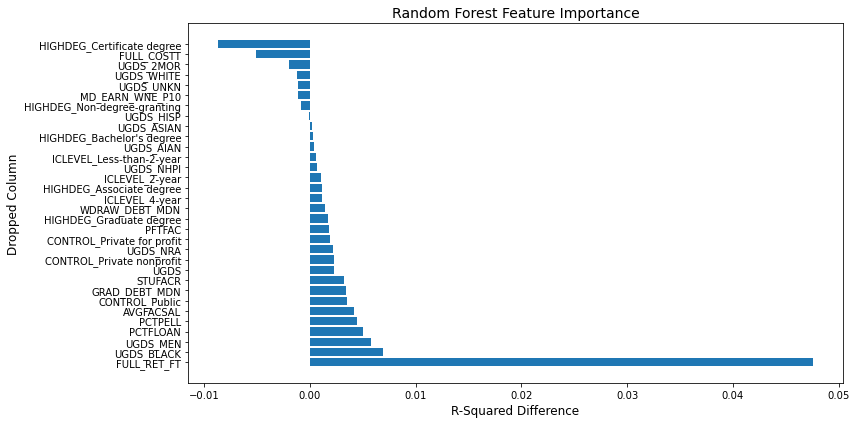

In [217]:
# Sorting for visual interpretation
results_df = results_df.sort_values('R-Squared Difference', ascending=False) 

# Enlarged figure size
plt.figure(figsize=(12, 6)) 

# Bar chart
plt.barh(results_df['Column'], results_df['R-Squared Difference']) 
plt.ylabel('Dropped Column') # Note the switched labels
plt.xlabel('R-Squared Difference') # Note the switched labels
plt.title('Random Forest Feature Importance')

# Larger font sizes (adjust as needed)
plt.xlabel('R-Squared Difference', fontsize=12)
plt.ylabel('Dropped Column', fontsize=12)
plt.title('Random Forest Feature Importance', fontsize=14)

plt.tight_layout()
plt.show()

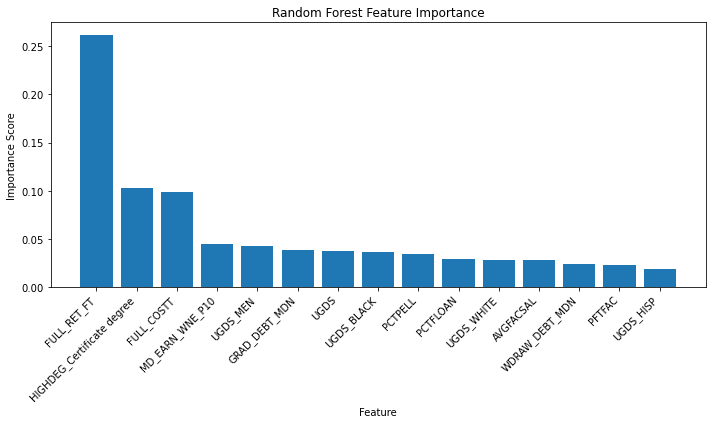

In [218]:
clf = RFR(n_estimators=200, max_depth=20, random_state=42)
clf.fit(X_train, y_train)

# Get feature importances
importances = clf.feature_importances_
feature_importances = sorted(zip(importances, X.columns), reverse=True)
feature_names = [name for _, name in feature_importances]
importances = [score for score, _ in feature_importances]

# Top N features 
n_features = 15
feature_names = feature_names[:n_features]
importances = importances[:n_features]

# Create bar chart
plt.figure(figsize=(10, 6)) 
plt.bar(feature_names, importances)
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.title('Random Forest Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

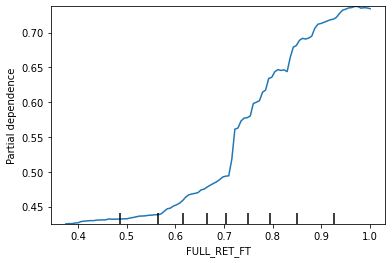

In [221]:
PartialDependenceDisplay.from_estimator(clf, X, [2])